# Tire Texture Image Classification

## Menyiapkan Pustaka

In [1]:
import tensorflow as tf
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg
import os

from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model


## Load & Ekstrak Data

In [2]:
data_url = 'https://github.com/wildanmjjhd29/Tire-Texture-Image-Classification/releases/download/v1.0/Tire_Texture.zip'
urllib.request.urlretrieve(data_url,'Tire_Texture.zip')
local_file = 'Tire_Texture.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [3]:
base_dir = '/content/data/Tire Textures'
train_dir = os.path.join(base_dir,'training_data' )
test_dir = os.path.join(base_dir,'testing_data')

In [4]:
os.listdir(train_dir)

['normal', 'cracked']

In [5]:
os.listdir(test_dir)

['normal', 'cracked']

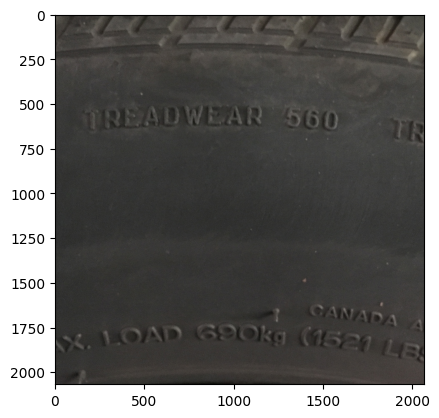

In [6]:
plt.imshow(mpimg.imread('/content/data/Tire Textures/testing_data/normal/IMG_4261.jpg'))

## Augmentasi Gambar

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.1
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size= 32,
    class_mode = 'binary',
    target_size = (180,180),
    subset = 'training'
)

Found 634 images belonging to 2 classes.


In [9]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size= 32,
    class_mode = 'binary',
    target_size = (180,180),
    subset = 'validation'
)

Found 69 images belonging to 2 classes.


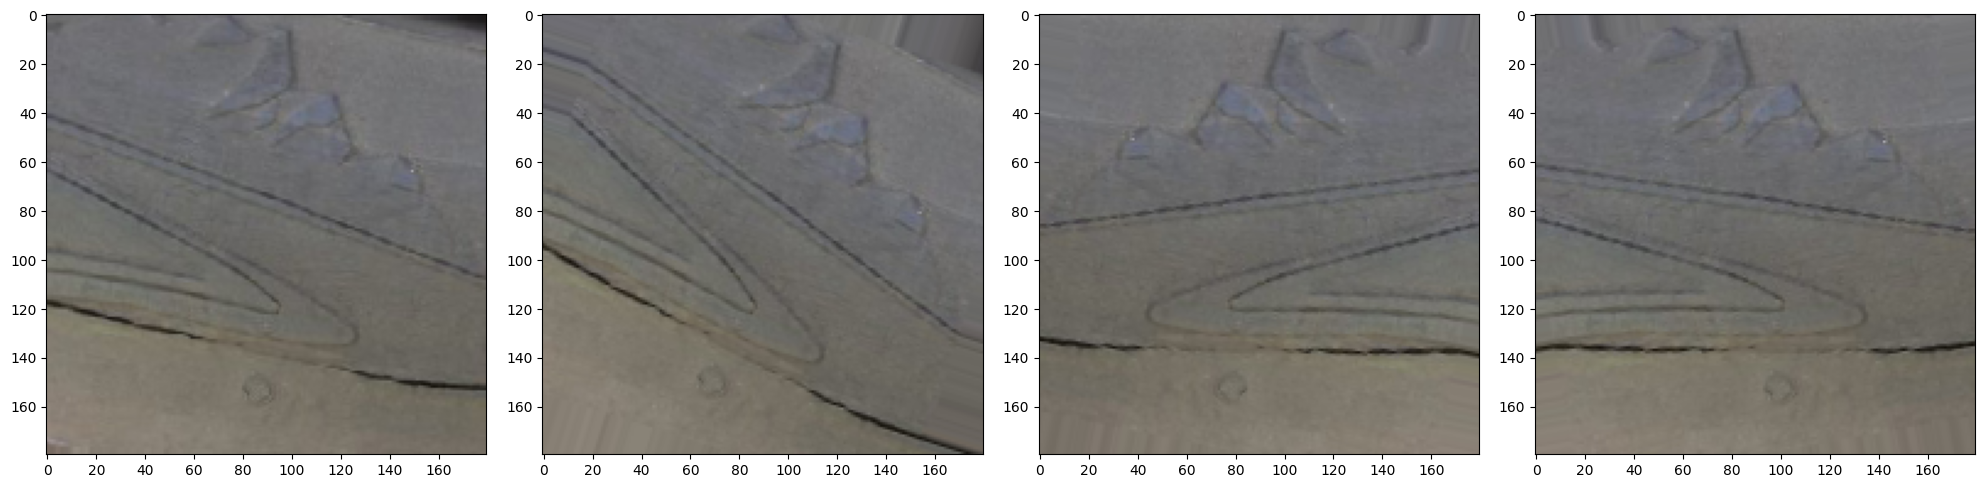

In [10]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1, len(images_arr), figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

augmented_images = [train_generator[1][0][0] for i in range(4)]
plotImages(augmented_images)

In [11]:
test_datagen = ImageDataGenerator(
    rescale = 1./225
)

test_generator= test_datagen.flow_from_directory(
    test_dir,
    batch_size= 32,
    class_mode = 'binary',
    target_size = (180,180),
)

Found 325 images belonging to 2 classes.


## Membuat Model

In [12]:

# Tentukan ukuran input gambar yang ingin Anda gunakan
input_shape = (180, 180, 3)

# Dapatkan pre-trained InceptionV3 model tanpa lapisan klasifikasi teratas (include_top=False)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Bekukan lapisan-lapisan pre-trained
base_model.trainable = False

# Buat model transfer learning dengan menambahkan lapisan-lapisan klasifikasi tambahan di atas base model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22065185 (84.17 MB)
Trainable params: 26240

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [15]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 25,
    verbose = 2,
    callbacks=[callbacks]
)

Epoch 1/25
20/20 - 70s - loss: 0.7794 - accuracy: 0.6593 - val_loss: 0.3517 - val_accuracy: 0.8261 - 70s/epoch - 3s/step
Epoch 2/25
20/20 - 62s - loss: 0.3332 - accuracy: 0.8722 - val_loss: 0.2022 - val_accuracy: 0.9275 - 62s/epoch - 3s/step
Epoch 3/25

Akurasi telah mencapai >90%!
20/20 - 62s - loss: 0.2267 - accuracy: 0.9196 - val_loss: 0.1873 - val_accuracy: 0.9565 - 62s/epoch - 3s/step


In [17]:
def plot_acc_loss(history):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].set_title('Loss')
  ax[0].plot(history.epoch, history.history['loss'],label = 'Train Loss')
  ax[0].plot(history.epoch, history.history['val_loss'],label = 'Valid Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].plot(history.epoch, history.history['accuracy'],label = 'Train Accuracy')
  ax[1].plot(history.epoch, history.history['val_accuracy'],label = 'Valid Accuracy')
  ax[1].legend()

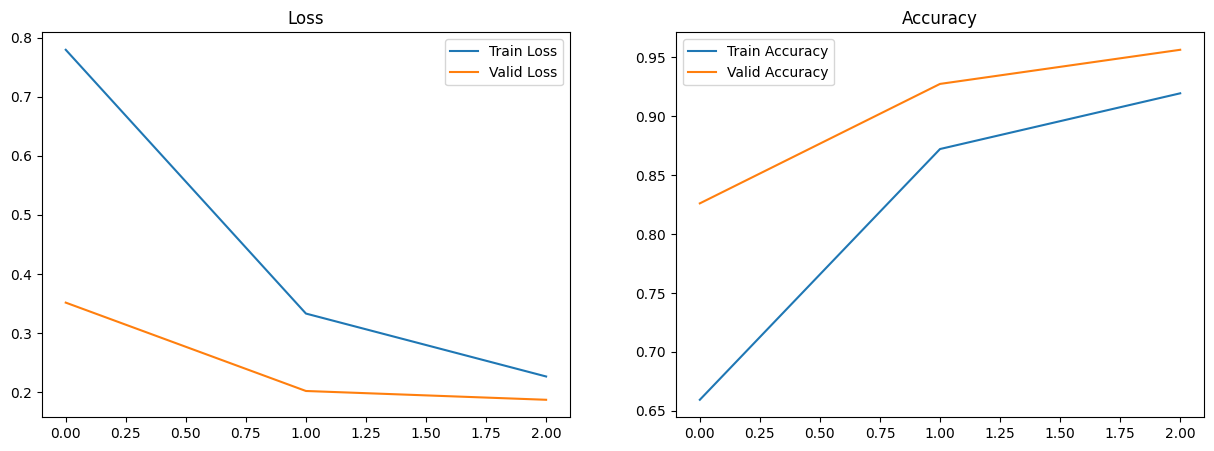

In [18]:
plot_acc_loss(history)

In [19]:
train_generator.class_indices

{'cracked': 0, 'normal': 1}

In [23]:
def predict_image_class(model, file_path):
    img = image.load_img(file_path, target_size=(180,180))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    plt.imshow(mpimg.imread(file_path))
    plt.show()
    if classes == 1:
        print('Normal')
    else:
        print('Cracked')

1/1 [==============================] - 0s 133ms/step


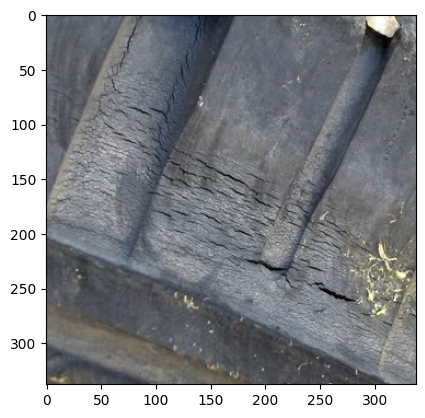

Cracked


In [27]:
predict_image_class(model,'/content/data/Tire Textures/testing_data/cracked/Cracked-10.jpg')